# sst-nhf feedback : 

Computes net surface heat flux anomalies (NHFA; sum of latent and sensible heat fluxes and longwave and shortwave radiations) regressed onto surface temperature anomalies (SSTA) both in the eastern equatorial Pacific (horizontal Niño3 average).

#### Reference observations:
TropFlux 1979-2018 (main)

NHF: OAFlux-ISCCP 1984-2009, DEEP-C 1985-2016, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023
SST: ERSSTv5 1854-2023, HadISST 1870-2023, COBE2 1850-2023, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [1]:
from esmvalcore.dataset import Dataset

from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

In [2]:
model_ts_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    # timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}
model_ts_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacello', mip='Ofx')

model_ts = {name: dataset.load() for name, dataset in model_ts_datasets.items()}

In [3]:
model_hfls_datasets = { 
"ACCESS-ESM1-5": 
    Dataset(
    short_name='hfls',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    # timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

model_hfls_datasets["ACCESS-ESM1-5"].add_supplementary(short_name='areacella', mip='fx')

#rest variables
model_other = {}
for cvar in ['hfss','rlds','rlus','rsds','rsus']:
    
    model_other[cvar] = model_hfls_datasets["ACCESS-ESM1-5"].copy(short_name=cvar)

# load cubes, formula nhf


In [4]:
model_hfls = {name: dataset.load() for name, dataset in model_hfls_datasets.items()}
model_rest = {name: dataset.load() for name, dataset in model_other.items()}

 hfls: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/hfls/gn/v20191115/hfls_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 hfls: attribute positive not present
loaded from file 
 hfss: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/hfss/gn/v20191115/hfss_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 hfss: attribute positive not present
loaded from file 
 rlds: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/rlds/gn/v20191115/rlds_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 rlds: attribute positive not present
loaded from file 
 rlus: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/rlus/gn/v20191115/rlus_Amon_ACCESS-ESM

In [6]:
print(model_hfls['ACCESS-ESM1-5'].data.max(), model_hfls['ACCESS-ESM1-5'].data.mean())
model_rest
test = - model_hfls['ACCESS-ESM1-5']
test.data.max() , test.data.mean(), test.data.min()

550.3307 69.14513


(73.619156, -69.14512481133171, -550.3307)

In [48]:
# nhf = -*hfls* -hfss + rlds - rlus + rsds - rsus #if 'd' make positive
model_nhf = - model_hfls['ACCESS-ESM1-5'] - model_rest['hfss'] + model_rest['rlds']- model_rest['rlus']+ model_rest['rsds']- model_rest['rsus']
model_nhf.data.max()

318.27628

In [ ]:
obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    timerange="19790101/20190101",
    tier=2),
"ERA-Interim":
    Dataset(
    short_name='ts',
    dataset='ERA-Interim',
    mip="Amon",
    project='OBS6',
    type='reanaly',
    tier=3)
}
obs_tauu_datasets = { ##zos
 "ERA-Interim": 
     Dataset(
     short_name='tauu',
     dataset='ERA-Interim',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3)
}

In [ ]:
model_ssh_datasets = {name: dataset.load() for name, dataset in model_ssh_datasets.items()}
model_tauu = {name: dataset.load() for name, dataset in model_tauu.items()}

# obs_tos_datasets = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}
# obs_tauu_datasets = {name: dataset.load() for name, dataset in obs_tauu_datasets.items()}

In [8]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [49]:
def east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}

    cube = regrid(cube, target_grid="1x1", scheme="linear")
    # cube = convert_units(cube, units="degC")
    cube = extract_region(cube, **nino3_region)
    # cube = detrend(cube, dimension="time", method="linear")
    cube = area_statistics(cube, operator='mean')
    cube = anomalies(cube, period="full")
    
    return cube


In [ ]:
type(model_ts['ACCESS-ESM1-5'].cell_measure())
# model_nhf_prep['ACCESS-ESM1-5']
print(model_ts_prep['ACCESS-ESM1-5'].data.mean())
qplt.plot(model_ts_prep['ACCESS-ESM1-5'])

cube = model_ts['ACCESS-ESM1-5']
nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
cube = extract_region(cube, **nino3_region)
cube = detrend(cube, dimension="time", method="linear")
celarea = cube.cell_measure()
cube = anomalies(cube, period="full")

cube.add_cell_measure(celarea, [1,2])
cube = area_statistics(cube, operator='mean')

# model_nhf_prep['ACCESS-ESM1-5']
qplt.plot(cube), cube.data.mean()

In [50]:
model_ts_prep = {name: east(dataset) for name, dataset in model_ts.items()}
model_nhf_prep = {'ACCESS-ESM1-5': east(model_nhf)}

# obs_tos_prep = {name: sst_east(dataset) for name, dataset in obs_tos_datasets.items()}
# obs_tauu_prep = {name: taux_west(dataset) for name, dataset in obs_tauu_datasets.items()}

## Calculate Linear regression

In [51]:
# scp.LinReg(model_tauu_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data).intcpt
B_data = model_ts_prep["ACCESS-ESM1-5"].data
B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, model_nhf_prep["ACCESS-ESM1-5"].data, rcond=None)
coefs

masked_array(data=[2.3525236 , 0.25193423],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

# Diagnostic Level 1

-3.2507362 -70.46447 2.9968243 67.892944
2.3525234806702193 0.25193423895592576
(1980,) (1980,)
W m-2 degC


Text(0.02, 0.9, 'slope: 2.35 ')

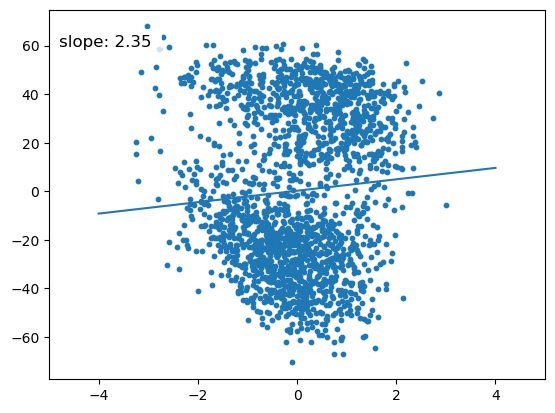

In [52]:
from scipy.stats import linregress
xseq = np.linspace(-4, 4, num=100)
print(model_ts_prep["ACCESS-ESM1-5"].data.min(), model_nhf_prep["ACCESS-ESM1-5"].data.min(), 
      model_ts_prep["ACCESS-ESM1-5"].data.max(), model_nhf_prep["ACCESS-ESM1-5"].data.max())
# linregress(model_tauu_prep["ACCESS-ESM1-5"].data, model_tos_prep["ACCESS-ESM1-5"].data)
slope, intcpt, _,_,_ = linregress(model_ts_prep["ACCESS-ESM1-5"].data, model_nhf_prep["ACCESS-ESM1-5"].data)
plt.plot(xseq, intcpt+slope*xseq)
print(slope, intcpt)
mod_slope = slope

# slope, intcpt, _,_,_ = linregress(obs_tos_prep["HadISST"].data, obs_tauu_prep["ERA-Interim"].data)
# plt.plot(xseq, intcpt+slope*xseq, color='black')
# metric_val = abs((mod_slope-slope)/slope)*100

print(model_nhf_prep["ACCESS-ESM1-5"].shape, model_ts_prep["ACCESS-ESM1-5"].shape) #scatter plot
print(model_nhf_prep["ACCESS-ESM1-5"].units, model_ts_prep["ACCESS-ESM1-5"].units)
plt.scatter(model_ts_prep["ACCESS-ESM1-5"].data, model_nhf_prep["ACCESS-ESM1-5"].data, s=10)

# print(obs_tos_prep["HadISST"].shape, obs_tauu_prep["ERA-Interim"].shape)
# plt.scatter(obs_tos_prep["HadISST"].data, obs_tauu_prep["ERA-Interim"].data,s=20, c='black', marker='D')
plt.xlim(-5,5)

## text slope
plt.text(0.02, 0.9, f'slope: {mod_slope:.2f} ', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# print(metric_val)

# Diagnostic Level 2

In [ ]:
# SPLIT BY X<0 AND X>0 (temp)
import pandas as pd

model_tauu_prep["ACCESS-ESM1-5"].data, model_ssh_prep["ACCESS-ESM1-5"]
# matrix/cube? split by tauua 0 -df?time rows, col tauu,ssh create tuple points, zip

df = pd.DataFrame({'tauu':model_tauu_prep["ACCESS-ESM1-5"].data, 'ssh':model_ssh_prep["ACCESS-ESM1-5"].data})
print(df.shape)
df.loc[df['tauu']<0]

xseq = np.linspace(-50, 0, num=50)
slope, intcpt, _,_,_ = linregress(df.loc[df['tauu']<0, 'tauu'], df.loc[df['tauu']<0, 'ssh'])
plt.plot(xseq, intcpt+slope*xseq, linewidth=3)
print(slope)
xseq = np.linspace(0, 50, num=50)
slope, intcpt, _,_,_ = linregress(df.loc[df['tauu']>0, 'tauu'], df.loc[df['tauu']>0, 'ssh'])
plt.plot(xseq, intcpt+slope*xseq, color='red', linewidth=3)
print(slope)

plt.scatter(model_tauu_prep["ACCESS-ESM1-5"].data, model_ssh_prep["ACCESS-ESM1-5"].data, c='k', s=10)
xseq = np.linspace(-50, 50, num=50)
slope, intcpt, _,_,_ = linregress(df['tauu'], df['ssh'])
plt.plot(xseq, intcpt+slope*xseq, c='black')
print(slope)
plt.xlim(-50,50)
plt.ylim(-25,25)
plt.grid(linestyle='--')

In [ ]:
#level 3 zonal runningaverage
from esmvalcore.preprocessor import meridional_statistics

def ssh_eqp(cube):
    nino3_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    # cube = mask_landsea(cube, mask_out="land") #irregular
    cube = convert_units(cube, units="cm")
    cube = extract_region(cube, **nino3_region)
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear")
    cube = meridional_statistics(cube,operator='mean')
    cube = rolling_window_statistics(cube, coordinate='longitude',operator='mean',window_length=30)
    
    return cube

def taux_west_3(cube):
    region = {"start_longitude": 160., "end_longitude": 210., "start_latitude": -5., "end_latitude": 5.}
    # cube = extract_time(cube, start_year=1979, end_year=2000, start_month=1, end_month=12, start_day=1, end_day=31)
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="1e-3 N/m2") #slope value
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="full")
    cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_region(cube, **
                          region)
    cube = area_statistics(cube,operator='mean')
    return cube 

#lin_regress

In [ ]:
model_tos_prep = {name: ssh_eqp(dataset) for name, dataset in model_ssh_datasets.items()}
model_tauu_prep = {name: taux_west_3(dataset) for name, dataset in model_tauu.items()}

In [ ]:
# reg2_mod = lin_regress_matrix(model_tos_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"])
print(model_tos_prep["ACCESS-ESM1-5"].shape, model_tauu_prep["ACCESS-ESM1-5"].shape)

B_data = model_tauu_prep["ACCESS-ESM1-5"].data
B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, model_tos_prep["ACCESS-ESM1-5"].data, rcond=None)
coefs#.shape #add long coordinate

In [ ]:
#spilt tauu
from esmvalcore.preprocessor import mask_above_threshold, mask_below_threshold

cb = model_tauu_prep["ACCESS-ESM1-5"] #mask, get mask, apply
cb_mask = mask_below_threshold(cb.copy(), 0.0000)
np.unique(cb_mask.data.mask, return_counts=True)
# qplt.plot(model_tauu_prep["ACCESS-ESM1-5"])

maskedTime = np.ma.masked_array(cb_mask.coord('time').points, mask=cb_mask.data.mask)
# [events.coord('time').units.num2date(time) for time in maskedTime.compressed()]
maskedTime.compressed()
time_con = iris.Constraint(time=lambda cell: cell.point in maskedTime.compressed())

tos = model_tos_prep["ACCESS-ESM1-5"]
cube = tos.extract(time_con)
# model_tauu_prep["ACCESS-ESM1-5"].data.mean()
cube #tos.data
# temp_tos = model_tos_prep["ACCESS-ESM1-5"]
# temp_tos.data.mask = cb_mask.data.mask #extract by time constraint?
# temp_tos.data.shape, cb_mask.data.shape

In [ ]:
from scipy.stats import linregress
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'
        
def lin_regress(cube_ssta, cube_nino34): #1d pattern
    slope_ls = []
    for lon_slice in cube_ssta.slices(['time']): 
        res = linregress(cube_nino34.data, lon_slice.data)
        slope_ls.append(res[0])

    return cube_ssta.coord('longitude').points, slope_ls

reg_mod = lin_regress( model_tos_prep["ACCESS-ESM1-5"], model_tauu_prep["ACCESS-ESM1-5"])
plt.plot(*reg_mod)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

##split tauu negative from positive #combine cube on time? #extract timevalues? -month,yeah